In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure
from PIL import Image
import requests
from io import BytesIO
import os
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import re

import warnings
warnings.simplefilter("ignore")

# Getting data

## Reading from colab into the notebook

In [3]:
# retrieve data from pickle files
csv_product_file = 'products.csv'
csv_review_file = 'reviews.csv'

# product_data_list
all_product_data_list = pd.read_csv(csv_product_file)

# product_review_list
all_review_data_list = pd.read_csv(csv_review_file)

# Data preprocessing

## Reset here

In [4]:
# Code for resetting data
p_data = all_product_data_list.copy()
r_data = all_review_data_list.set_index('product_id')
p_data = p_data.set_index('product_id')

## Join with Ratings data

In [5]:
ratings_data = r_data.groupby('product_id').agg({'averageRating': 'mean', 'countRatings': 'mean'})
p_data = p_data.join(ratings_data)

In [6]:
p_data.head()

,designer_name,displayName,length,neckline,productDetails,retailPrice,season,sleeve,stylistNotes,price_base,...,embellishments_pastels,embellishments_lace,embellishments_pockets,embellishments_metallics,embellishments_peplum,embellishments_sequins,embellishments_beaded,product_img_link,averageRating,countRatings
product_id,,,,,,,,,,,,,,,,,,,,,
CRCR18,Cara Cara New York,Juju Dress,tea_length,square,<p>White floral (100% Cotton Poplin). Casual d...,USD 525.00,spring_summer,sleeveless,<p>This Cara Cara New York dress features a ch...,50.0,...,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...,7.0,3.0
ADAMC171,Adam Lippes Collective,Floral Pleated Midi Dress,tea_length,square,"<p>Chiffon (97% Cotton, 3% Spandex). Casual Dr...",USD 445.00,spring_summer,sleeveless,<p>The Floral Pleated Midi Dress by Adam Lippe...,40.0,...,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...,9.0,3.0
MDW381,Madewell,Bianca Dress,tea_length,sweetheart,<p>Blue striped (100% Cotton). Casual dress. S...,USD 138.00,spring_summer,sleeveless,<p>This breezy blue and white striped midi dre...,30.0,...,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...,8.0,11.0
SRUE1,Rue Sophie,Eli Dress,tea_length,square,"<p>Off-white (67% Rayon, 26% Nylon, 7% Spandex...",USD 188.00,spring_summer,sleeveless,<p>This Sophie Rue white midi dress offers a t...,30.0,...,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...,8.0,4.0
ALC289,A.L.C.,Alexandria Midi Dress,tea_length,v_neck,<p>White (100% Cotton). Casual dress. Cap slee...,USD 495.00,spring_summer,cap_sleeve,<p>This A.L.C. white dress features a twist-fr...,45.0,...,0,0,0,0,0,0,0,https://pc-ap.rtrcdn.com/productimages/front/1...,9.0,7.0


## Fixing variable types

### Retail price

In [7]:
price_data = p_data['retailPrice'].str.extract('([A-Z]+)\s+([\d]+)', expand=True)
price_data.columns = ['retail_price_unit', 'retail_price_value']
p_data = p_data.join(price_data)
p_data = p_data.astype({'retail_price_value': 'float'})
p_data = p_data.drop(columns = ['retail_price_unit', 'retailPrice'])

### Numerical variables

In [8]:
p_data = p_data.astype({'price_base': 'float', 'price_adjusted': 'float'})

## Missing value treatment

In [9]:
pd.set_option("display.max_rows",None)
print(p_data.isna().sum())
pd.set_option("display.max_rows",60)

designer_name                        0
displayName                          0
length                            3995
neckline                          2579
productDetails                       0
season                               0
sleeve                            1763
stylistNotes                         0
price_base                           0
price_adjusted                       0
ageRanges_teens                      0
ageRanges_early_twenties             0
ageRanges_late_twenties              0
ageRanges_thirties                   0
ageRanges_forties_plus               0
bodyTypes_apple                      0
bodyTypes_athletic                   0
bodyTypes_full_bust                  0
bodyTypes_hourglass                  0
bodyTypes_pear                       0
bodyTypes_petite                     0
bodyTypes_straight_narrow            0
bodyTypes_bump_friendly              0
colors_green                         0
colors_white                         0
colors_print             

### countRatings

In [10]:
#Imputing values for countRatings
p_data.loc[p_data['countRatings'].isna(), 'countRatings'] = 0

### averageRating

In [11]:
#Imputing values for averageRating
p_data.loc[p_data['averageRating'].isna(), 'averageRating'] = 0

### Length, Neckline, and Sleeve

In [12]:
#Imputing values for length neckline and sleeve
p_data.loc[p_data['length'].isna(), 'length'] = p_data['length'].value_counts().index[0]
p_data.loc[p_data['neckline'].isna(), 'neckline'] = p_data['neckline'].value_counts().index[0]
p_data.loc[p_data['sleeve'].isna(), 'sleeve'] = p_data['sleeve'].value_counts().index[0]

## Dummy variables

### Designers

In [13]:
designers = p_data['designer_name'].value_counts().index
values = p_data['designer_name'].value_counts().values
top_designers = designers[values>150]
top_designers = ['designer_' + x for x in top_designers]
designer_dummies = pd.get_dummies(p_data['designer_name'], prefix='designer')[top_designers]
p_data = p_data.join(designer_dummies)

### Length

In [14]:
length_dummies = pd.get_dummies(p_data['length'], prefix='length')
p_data = p_data.join(length_dummies)
p_data = p_data.drop(columns = ['length'])

### Neckline

In [15]:
neckline_dummies = pd.get_dummies(p_data['neckline'], prefix='neckline')
p_data = p_data.join(neckline_dummies)
p_data = p_data.drop(columns = ['neckline'])

### season


In [16]:
season_dummies = pd.get_dummies(p_data['season'], prefix='season')
p_data = p_data.join(season_dummies)
p_data = p_data.drop(columns = ['season'])

### sleeve


In [17]:
sleeve_dummies = pd.get_dummies(p_data['sleeve'], prefix='sleeve')
p_data = p_data.join(sleeve_dummies)
p_data = p_data.drop(columns = ['sleeve'])

# EDA

In [18]:
# Columns and data types
pd.set_option("display.max_rows", None)
print(p_data.dtypes)
pd.set_option("display.max_rows", 60)

designer_name                      object
displayName                        object
productDetails                     object
stylistNotes                       object
price_base                        float64
price_adjusted                    float64
ageRanges_teens                     int64
ageRanges_early_twenties            int64
ageRanges_late_twenties             int64
ageRanges_thirties                  int64
ageRanges_forties_plus              int64
bodyTypes_apple                     int64
bodyTypes_athletic                  int64
bodyTypes_full_bust                 int64
bodyTypes_hourglass                 int64
bodyTypes_pear                      int64
bodyTypes_petite                    int64
bodyTypes_straight_narrow           int64
bodyTypes_bump_friendly             int64
colors_green                        int64
colors_white                        int64
colors_print                        int64
colors_multicolored                 int64
colors_blue                       

In [19]:
# Rows and columns
print('The dataset has ', p_data.shape[0], 'products and ' , p_data.shape[1], 'columns')

The dataset has  9405 products and  89 columns


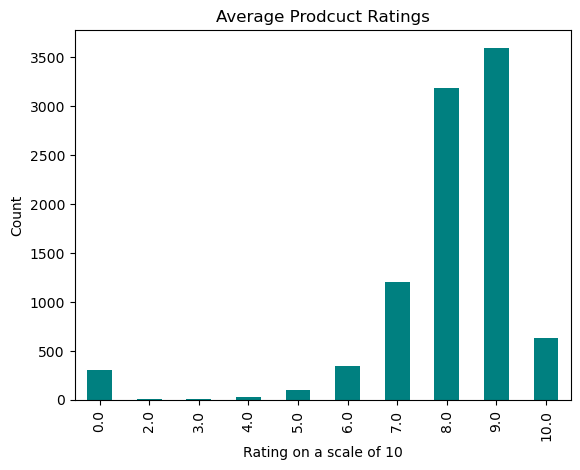

In [20]:
# averageRating
averageRating_data = p_data.groupby(p_data['averageRating']).size()
averageRating_data.plot.bar(color = 'teal')
plt.title('Average Prodcuct Ratings')
plt.xlabel('Rating on a scale of 10')
plt.ylabel('Count')
plt.show()

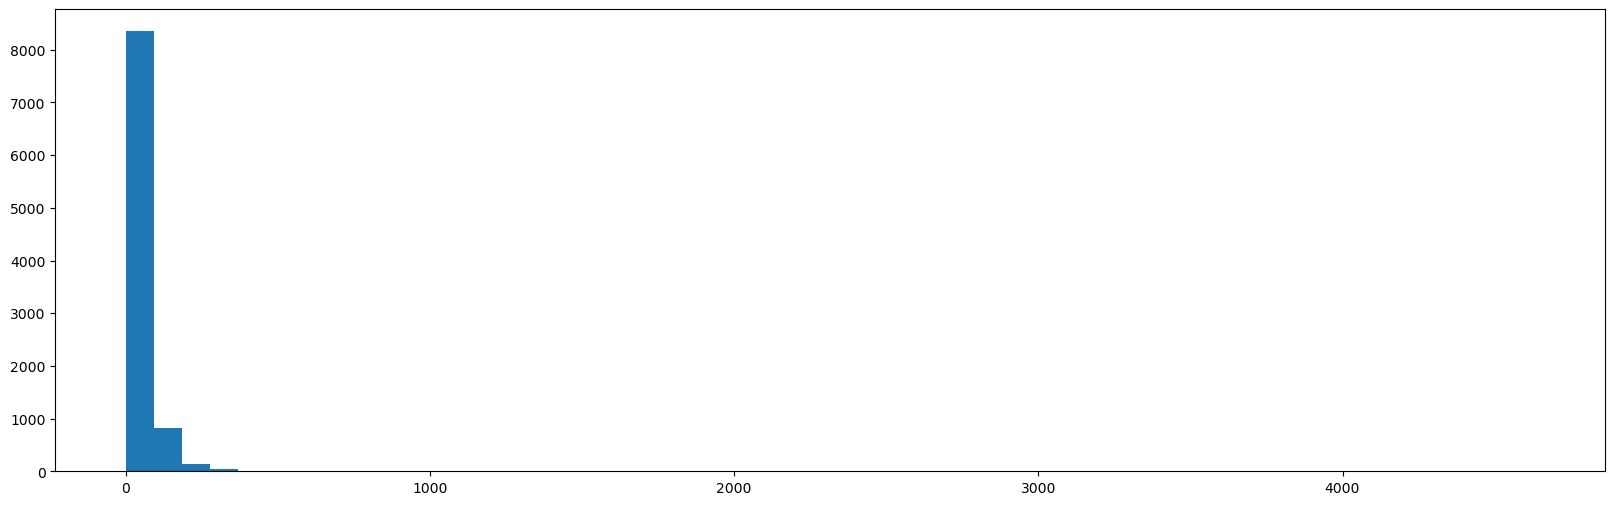

In [21]:
# countRatings
figure(num=None, figsize=(20, 6))
plt.hist(p_data['countRatings'], bins = 50)
plt.show()

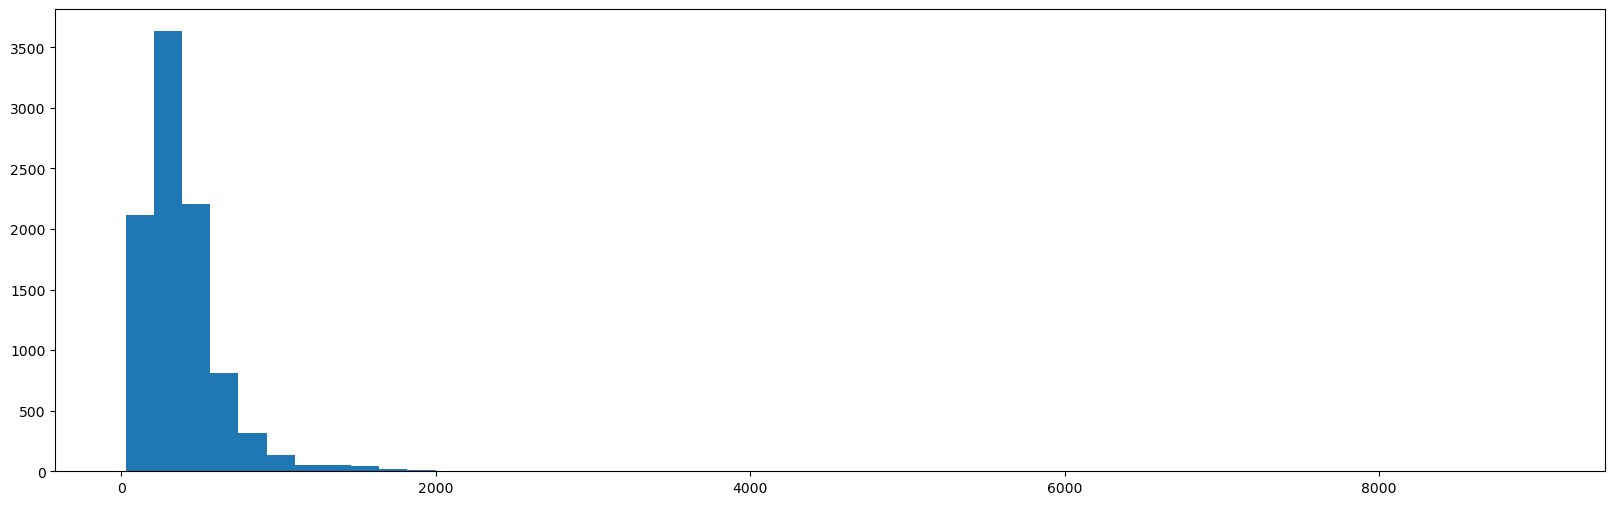

In [22]:
# retail_price_value
figure(num=None, figsize=(20, 6))
plt.hist(p_data['retail_price_value'], bins = 50)
plt.show()

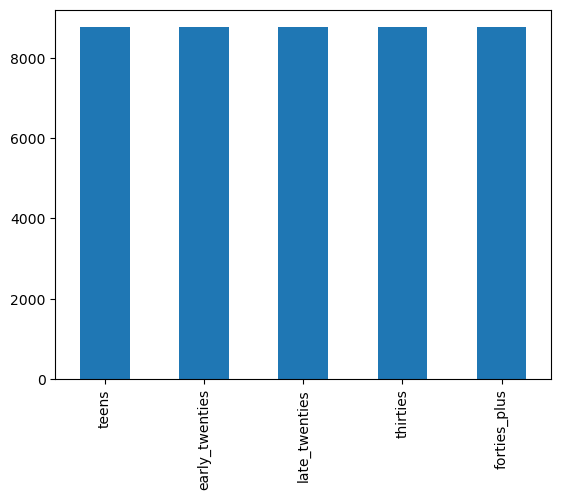

In [23]:
# ageRanges
ageRanges = [x for x in p_data.columns if x.startswith('ageRanges')]
ageRanges_data = p_data[ageRanges].sum().sort_values()
ageRanges_data.index = [x.replace('ageRanges_', "") for x in ageRanges_data.index]
ageRanges_data.plot(kind = 'bar')
plt.show()

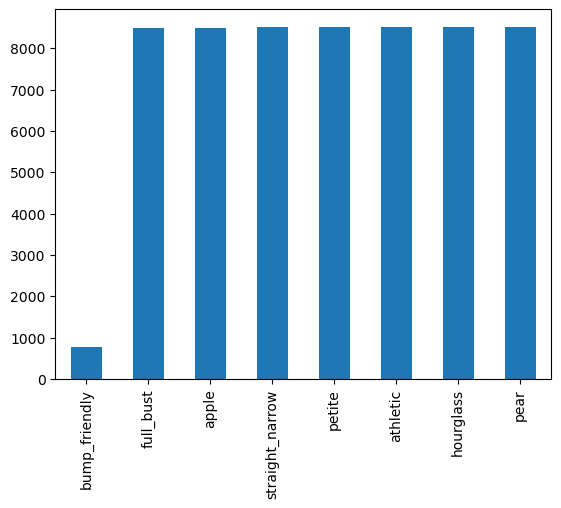

In [24]:
# bodyTypes
bodyTypes = [x for x in p_data.columns if x.startswith('bodyTypes')]
bodyTypes_data = p_data[bodyTypes].sum().sort_values()
bodyTypes_data.index = [x.replace('bodyTypes_', "") for x in bodyTypes_data.index]
bodyTypes_data.plot(kind = 'bar')
plt.show()

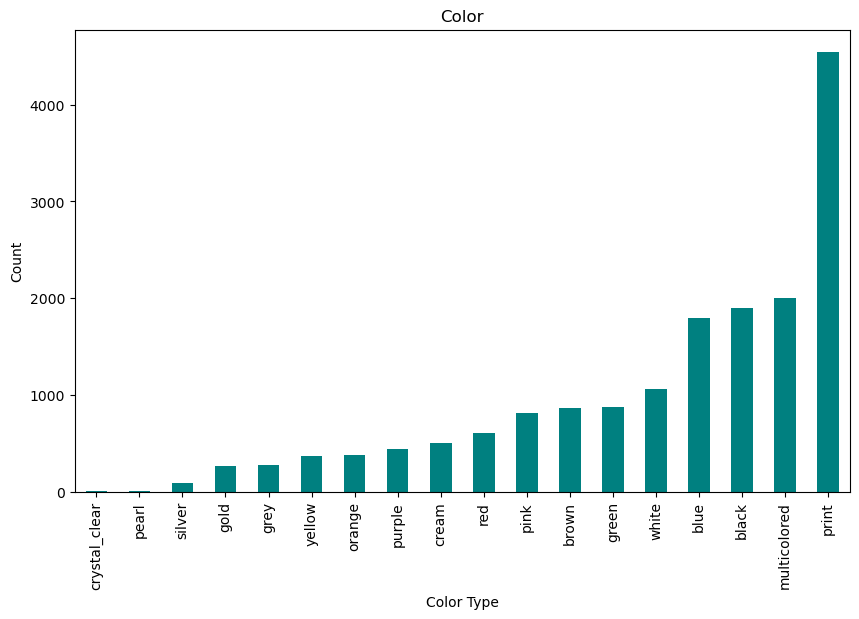

In [35]:
# colors
colors = [x for x in p_data.columns if x.startswith('colors')]
colors_data = p_data[colors].sum().sort_values()
colors_data.index = [x.replace('colors_', "") for x in colors_data.index]
figure(num=None, figsize=(10, 6))
colors_data.plot.bar(color = 'teal')
plt.title('Color')
plt.xlabel('Color Type')
plt.ylabel('Count')
plt.show()

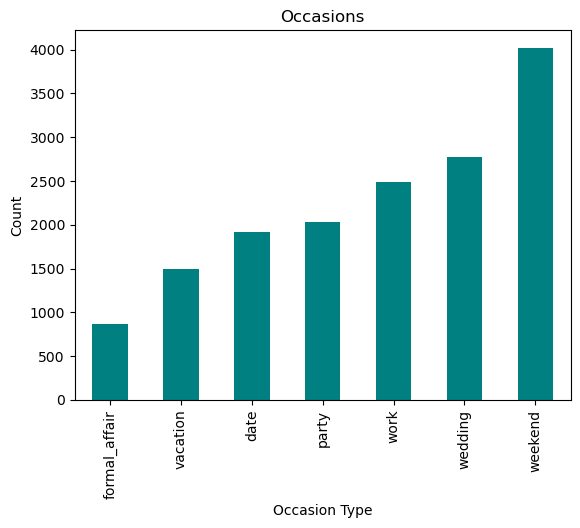

In [36]:
# occasions
occasions = [x for x in p_data.columns if x.startswith('occasions')]
occasions_data = p_data[occasions].sum().sort_values()
occasions_data.index = [x.replace('occasions_', "") for x in occasions_data.index]
occasions_data.plot.bar(color = 'teal')
plt.title('Occasions')
plt.xlabel('Occasion Type')
plt.ylabel('Count')
plt.show()

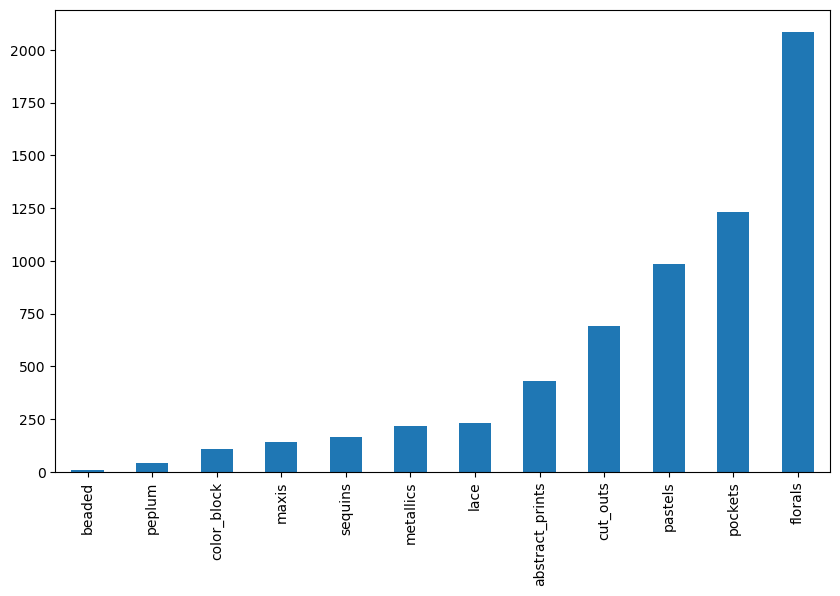

In [27]:
# embellishments
embellishments = [x for x in p_data.columns if x.startswith('embellishments')]
embellishments_data = p_data[embellishments].sum().sort_values()
embellishments_data.index = [x.replace('embellishments_', "") for x in embellishments_data.index]
figure(num=None, figsize=(10, 6))
embellishments_data.plot(kind = 'bar')
plt.show()

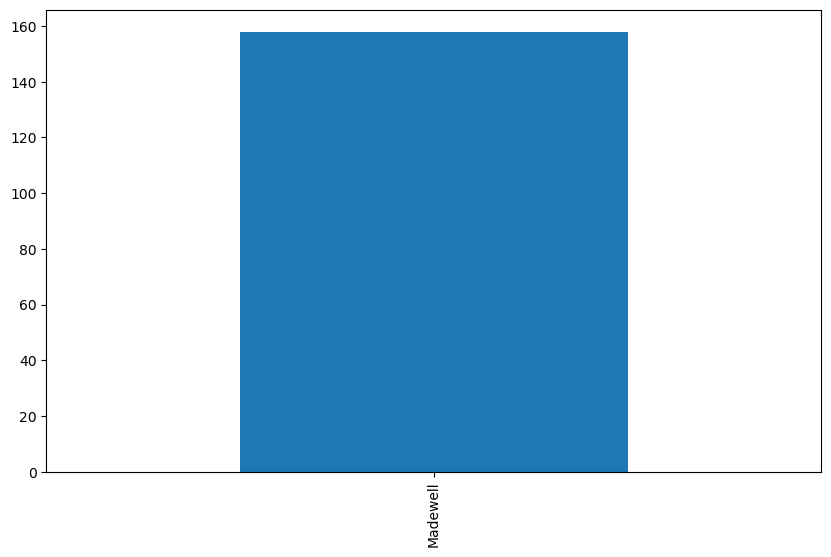

In [28]:
# designer
designer = [x for x in p_data.columns if x.startswith('designer_')]
designer.remove('designer_name')
designer_data = p_data[designer].sum().sort_values()
designer_data.index = [x.replace('designer_', "") for x in designer_data.index]
figure(num=None, figsize=(10, 6))
designer_data.plot(kind = 'bar')
plt.show()

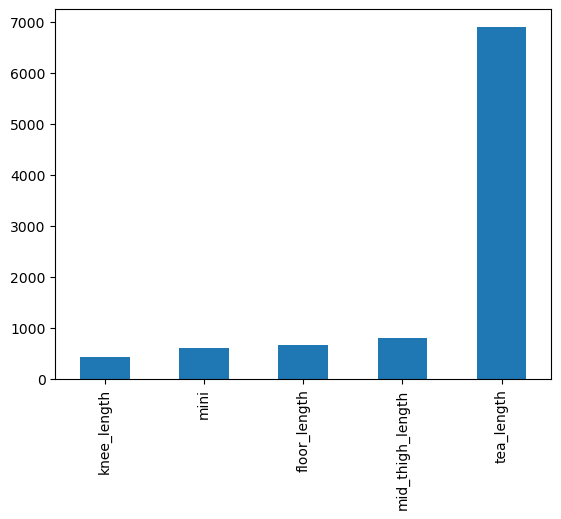

In [29]:
# length
length = [x for x in p_data.columns if x.startswith('length')]
length_data = p_data[length].sum().sort_values()
length_data.index = [x.replace('length_', "") for x in length_data.index]
length_data.plot(kind = 'bar')
plt.show()

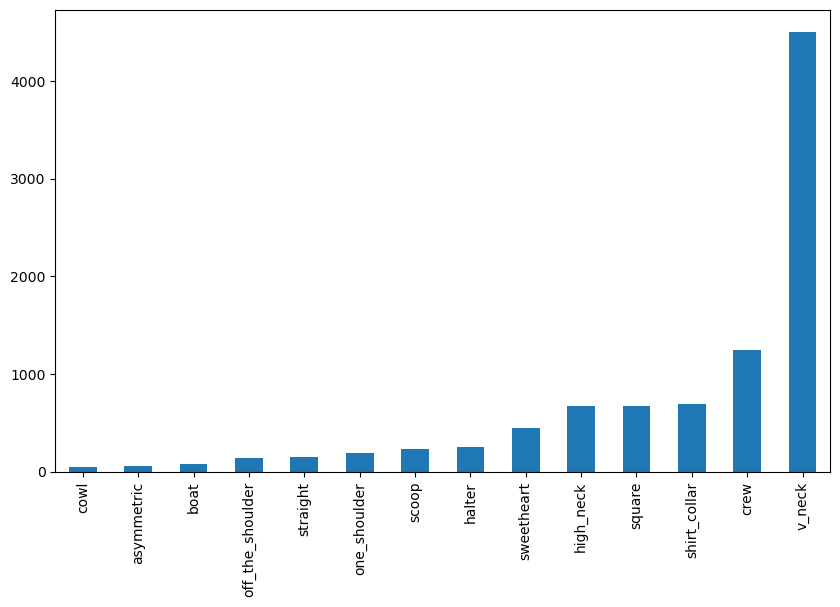

In [30]:
# neckline
neckline = [x for x in p_data.columns if x.startswith('neckline')]
neckline_data = p_data[neckline].sum().sort_values()
neckline_data.index = [x.replace('neckline_', "") for x in neckline_data.index]
figure(num=None, figsize=(10, 6))
neckline_data.plot(kind = 'bar')
plt.show()

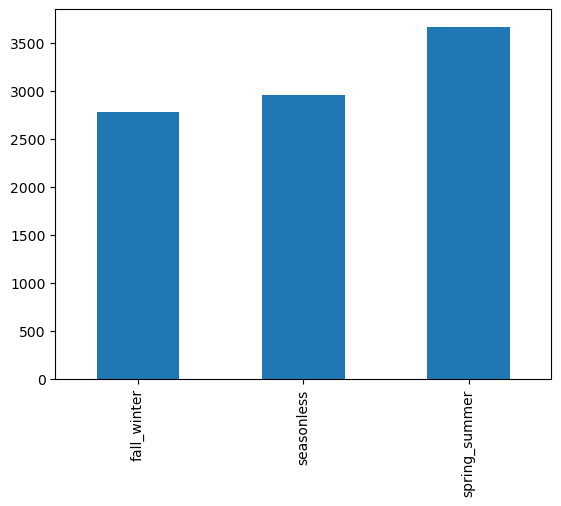

In [31]:
# season
season = [x for x in p_data.columns if x.startswith('season')]
season_data = p_data[season].sum().sort_values()
season_data.index = [x.replace('season_', "") for x in season_data.index]
season_data.plot(kind = 'bar')
plt.show()

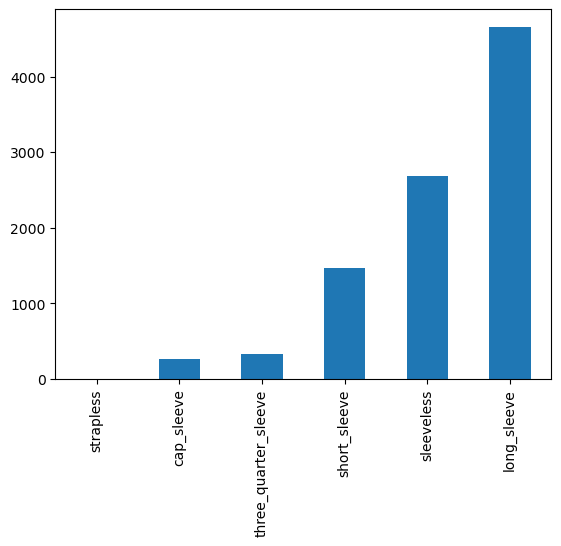

In [32]:
# sleeve
sleeve = [x for x in p_data.columns if x.startswith('sleeve')]
sleeve_data = p_data[sleeve].sum().sort_values()
sleeve_data.index = [x.replace('sleeve_', "") for x in sleeve_data.index]
sleeve_data.plot(kind = 'bar')
plt.show()

# Content Based Filtering

### Reset data here

In [33]:
p_data_content = p_data.copy()

In [34]:
p_data_content = p_data_content.drop(columns= ['displayName', 'designer_name', 'productDetails', 'stylistNotes', 'product_img_link'])

### Standardize columns

In [35]:
# Standardize each column vector
def standardize_columns(df):
  for colname in df.columns:
    if colname == 'product_id':
      continue
    else:
      mean_ = np.mean(df[colname])
      std_ = np.std(df[colname])
      df[colname] = (df[colname] - mean_) / std_
  return df

p_data_content_std = standardize_columns(p_data_content)

In [36]:
p_data_content_std.head()

,price_base,price_adjusted,ageRanges_teens,ageRanges_early_twenties,ageRanges_late_twenties,ageRanges_thirties,ageRanges_forties_plus,bodyTypes_apple,bodyTypes_athletic,bodyTypes_full_bust,...,neckline_v_neck,season_fall_winter,season_seasonless,season_spring_summer,sleeve_cap_sleeve,sleeve_long_sleeve,sleeve_short_sleeve,sleeve_sleeveless,sleeve_strapless,sleeve_three_quarter_sleeve
product_id,,,,,,,,,,,,,,,,,,,,,
CRCR18,-0.012062,-0.012062,0.272026,0.272026,0.272026,0.272026,0.272026,0.328687,0.3245,0.330273,...,-0.958234,-0.647287,-0.677695,1.250627,-0.169280,-0.990581,-0.429719,1.582847,-0.017863,-0.191589
ADAMC171,-0.327151,-0.327151,0.272026,0.272026,0.272026,0.272026,0.272026,0.328687,0.3245,0.330273,...,-0.958234,-0.647287,-0.677695,1.250627,-0.169280,-0.990581,-0.429719,1.582847,-0.017863,-0.191589
MDW381,-0.642241,-0.642241,0.272026,0.272026,0.272026,0.272026,0.272026,0.328687,0.3245,0.330273,...,-0.958234,-0.647287,-0.677695,1.250627,-0.169280,-0.990581,-0.429719,1.582847,-0.017863,-0.191589
SRUE1,-0.642241,-0.642241,0.272026,0.272026,0.272026,0.272026,0.272026,0.328687,0.3245,0.330273,...,-0.958234,-0.647287,-0.677695,1.250627,-0.169280,-0.990581,-0.429719,1.582847,-0.017863,-0.191589
ALC289,-0.169607,-0.169607,0.272026,0.272026,0.272026,0.272026,0.272026,0.328687,0.3245,0.330273,...,1.043586,-0.647287,-0.677695,1.250627,5.907364,-0.990581,-0.429719,-0.631773,-0.017863,-0.191589


### Singular Value Deomposition

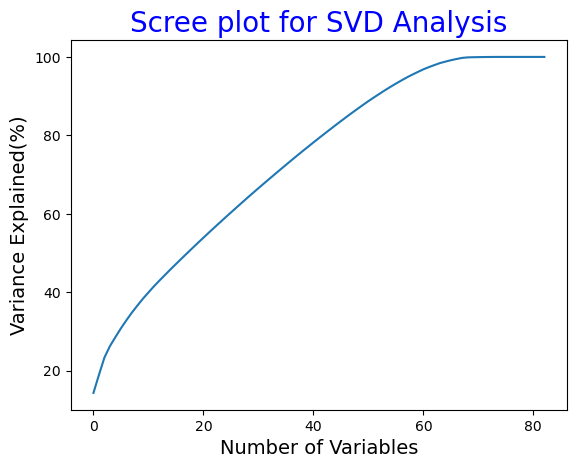

In [37]:
# products is a sparse matrix and therefore we carry out singiular value decomposition using SVD

# Scree Plot values
X = p_data_content_std.values
tsvd = TruncatedSVD(n_components=X.shape[1] - 1) #reduce just one variable
X_tsvd = tsvd.fit(X) #Train
var_ratio_exp = X_tsvd.explained_variance_ratio_.cumsum()

# Scree Plot
plt.xlabel('Number of Variables', fontsize=14, color='black')
plt.ylabel('Variance Explained(%)', fontsize=14, color='black')
plt.title ('Scree plot for SVD Analysis' ,fontsize=20, color='blue')
plt.plot(range(len(var_ratio_exp)), var_ratio_exp * 100) #plot
plt.show()

In [38]:
var_ratio_exp[60] * 100

96.83646449991824

In [39]:
# perform SVD using 60 principal components
svd = TruncatedSVD(n_components = 60,random_state = 63) #Define our SVD
normalizer = Normalizer(copy=False) #whole row to unit norm. Every document now is a unit vector
LSA = make_pipeline(svd, normalizer) #
Xnew = LSA.fit_transform(X)

In [41]:
# Create reduced products dataframe
products_SVD = pd.DataFrame(Xnew)
products_SVD = products_SVD.assign(product_id = p_data_content_std.index)
products_SVD = products_SVD.set_index('product_id')

In [42]:
products_SVD.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
product_id,,,,,,,,,,,,,,,,,,,,,
CRCR18,-0.217616,-0.394016,-0.054632,0.062700,-0.284474,-0.020864,-0.160394,0.012204,0.092376,0.032940,...,-0.017876,-0.161089,0.100546,-0.057199,0.172041,0.081467,0.015843,0.143385,-0.044633,0.020669
ADAMC171,-0.228587,-0.472950,-0.106787,0.092051,-0.299964,0.154459,-0.110743,-0.044809,0.079287,0.108762,...,-0.047822,-0.269663,0.122797,-0.073252,0.131001,0.046808,-0.033031,0.067920,0.038797,0.030398
MDW381,-0.124376,-0.222787,-0.218138,0.003113,-0.110097,-0.233648,0.069937,-0.162670,0.071777,0.038261,...,-0.002235,-0.023178,-0.111896,-0.088017,0.033888,0.008816,0.035153,-0.016142,-0.129474,-0.070086
SRUE1,-0.160560,-0.349660,-0.271560,0.010151,-0.242487,-0.385609,-0.001421,-0.140526,0.253873,-0.119310,...,-0.038855,-0.091341,0.058675,-0.086350,0.029856,-0.000309,0.038392,0.069734,-0.170821,-0.085450
ALC289,-0.086364,-0.227661,-0.029542,-0.035788,-0.164472,-0.120026,-0.119252,0.227370,-0.051466,-0.090694,...,0.067411,0.053071,0.094799,0.042031,-0.041658,0.046523,-0.103960,0.071434,-0.106812,-0.044459


### PCA

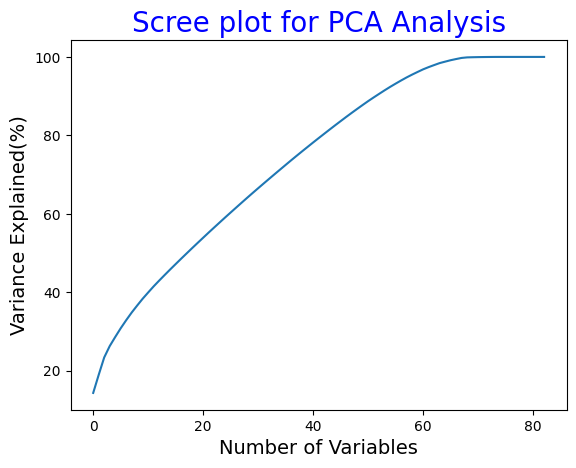

In [72]:
# products is a sparse matrix and therefore we carry out singiular value decomposition using PCA

# Scree Plot values
X = p_data_content_std.values
pca = PCA(n_components=X.shape[1] - 1) #reduce just one variable
X_pca = pca.fit(X) #Train
var_ratio_exp_pca = X_pca.explained_variance_ratio_.cumsum()

# Scree Plot
plt.xlabel('Number of Variables', fontsize=14, color='black')
plt.ylabel('Variance Explained(%)', fontsize=14, color='black')
plt.title ('Scree plot for PCA Analysis' ,fontsize=20, color='blue')
plt.plot(range(len(var_ratio_exp_pca)), var_ratio_exp_pca * 100) #plot
plt.show()

In [102]:
var_ratio_exp_pca[60] * 100

96.83646449991815

In [56]:
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction
pca = PCA(n_components=65, random_state=63)
X_pca = pca.fit_transform(X)

# Create reduced products dataframe
products_PCA = pd.DataFrame(X_pca)
products_PCA = products_PCA.assign(product_id=p_data_content_std.index)
products_PCA = products_PCA.set_index('product_id')

products_PCA.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
product_id,,,,,,,,,,,,,,,,,,,,,
CRCR18,-1.563470,-2.830822,-0.392504,0.450472,-2.043809,-0.149899,-1.152354,0.087681,0.663675,0.236659,...,0.585299,0.113827,1.030151,-0.320669,0.148494,-1.280641,-0.621672,-0.344523,-0.746580,0.040203
ADAMC171,-1.566025,-3.240127,-0.731585,0.630634,-2.055022,1.058185,-0.758691,-0.306981,0.543190,0.745116,...,0.320677,-0.226291,0.465311,0.265794,0.208253,0.567248,-0.313590,-0.522102,-0.665451,-0.077409
MDW381,-1.309749,-2.346074,-2.297123,0.032781,-1.159383,-2.460445,0.736480,-1.713011,0.755857,0.402910,...,0.092841,0.370178,-0.169980,-1.363432,-0.738044,0.375054,0.549399,0.331852,0.550589,1.384640
SRUE1,-1.036325,-2.256856,-1.752768,0.065522,-1.565117,-2.488885,-0.009170,-0.907014,1.638609,-0.770078,...,-0.001994,0.247799,0.450093,-1.102551,-0.551528,1.001436,0.644524,0.300852,0.334518,0.505103
ALC289,-0.768936,-2.026964,-0.263026,-0.318641,-1.464370,-1.068641,-1.061751,2.024375,-0.458226,-0.807491,...,0.414214,-0.925601,0.636007,-0.950997,-0.395840,1.454045,0.196768,-0.303492,0.632791,0.348566


In [74]:
from sklearn.random_projection import GaussianRandomProjection

# Perform Random Projection for dimensionality reduction
rp = GaussianRandomProjection(n_components=65, random_state=63)
X_rp = rp.fit_transform(X)

# Create reduced products dataframe
products_RP = pd.DataFrame(X_rp)
products_RP = products_RP.assign(product_id=p_data_content_std.index)
products_RP = products_RP.set_index('product_id')

products_RP.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
product_id,,,,,,,,,,,,,,,,,,,,,
CRCR18,-0.139657,0.069298,0.592094,0.167733,-1.103302,0.258477,0.497205,-0.489804,-0.225711,-1.952904,...,0.005722,-0.417119,0.674439,0.442488,-1.079621,0.919602,0.254773,0.129124,0.789616,-1.889777
ADAMC171,-0.213726,-0.135354,-0.364133,0.041647,-0.860819,0.064557,0.142337,-0.762337,0.744190,-1.275291,...,0.217024,0.487031,1.051797,0.600090,-0.920878,0.120052,-1.024485,0.010911,1.259523,-1.139956
MDW381,0.904552,0.432403,1.447219,0.520343,-0.849272,-0.330387,-1.425324,-2.049540,-0.480634,-0.564638,...,1.063430,-0.829729,-0.978380,-0.323538,-0.222998,-0.608989,-1.223768,2.029109,1.053792,0.219314
SRUE1,0.552043,0.144995,-0.227114,-0.459928,-1.750477,-0.171074,0.378282,-0.435779,0.795924,-0.391250,...,-0.113130,0.542408,-0.352732,0.369227,0.061128,0.976391,-0.916387,0.912511,0.864036,-0.984842
ALC289,-2.218650,0.691888,1.357573,-1.222025,-1.397229,-0.899342,-0.675019,1.447884,1.209591,0.142175,...,0.658819,0.637701,-0.433433,0.563050,-1.265365,0.806091,0.686075,-1.045628,1.383754,0.132630


### Cosine Similarity from RP

In [79]:
# Calculate cosine similarity among products
cs_rp = cosine_similarity(products_RP)
cs_matrix_rp = pd.DataFrame(cs_rp)
cs_matrix_rp.index = p_data_content_std.index
cs_matrix_rp.columns = p_data_content_std.index
cs_matrix_rp

product_id,CRCR18,ADAMC171,MDW381,SRUE1,ALC289,DLC264,SAO132,SLR156,CECE14,UJ188,...,RKB56,BDK149,ASR109,MAJE70,SLR141,RTF26,SDY17,CHPA31,PG46,SIM11
product_id,,,,,,,,,,,,,,,,,,,,,
CRCR18,1.000000,0.841516,0.142199,0.429978,-0.014681,0.061897,0.163629,0.218030,0.639111,0.442059,...,-0.153621,-0.126997,-0.451826,0.200689,-0.174362,-0.354149,-0.179036,-0.139259,0.154127,-0.168742
ADAMC171,0.841516,1.000000,0.312812,0.596646,0.096389,0.063769,0.352364,0.120476,0.773647,0.484251,...,-0.143644,-0.203662,-0.375335,0.270879,-0.243587,-0.397160,-0.181692,-0.195527,-0.020321,-0.120821
MDW381,0.142199,0.312812,1.000000,0.376890,0.030658,-0.082424,0.315208,0.247881,0.075243,-0.015736,...,-0.050504,-0.032743,-0.042296,0.443109,-0.213028,-0.360982,0.165312,-0.263469,0.024385,-0.090243
SRUE1,0.429978,0.596646,0.376890,1.000000,0.258668,0.414322,0.429706,0.278892,0.386937,0.317737,...,-0.385171,-0.076510,-0.146301,0.482488,-0.080018,-0.497998,0.132385,-0.089712,-0.170258,-0.017815
ALC289,-0.014681,0.096389,0.030658,0.258668,1.000000,0.001661,0.217437,0.213336,-0.083998,0.063526,...,-0.056900,-0.008021,0.047990,0.217068,-0.115175,-0.038056,-0.230959,0.102875,-0.145228,0.050197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RTF26,-0.354149,-0.397160,-0.360982,-0.497998,-0.038056,0.082779,-0.341783,-0.285404,-0.257189,-0.141770,...,0.403422,0.125588,0.321054,-0.505599,0.195891,1.000000,-0.111875,0.111893,-0.092662,0.215336
SDY17,-0.179036,-0.181692,0.165312,0.132385,-0.230959,0.114875,-0.218601,0.039697,-0.087114,-0.124859,...,-0.032105,0.064570,0.080347,0.321297,0.104486,-0.111875,1.000000,0.150081,0.122402,0.263223
CHPA31,-0.139259,-0.195527,-0.263469,-0.089712,0.102875,0.106921,-0.080120,0.351412,-0.033866,0.095671,...,-0.064071,-0.077778,-0.089721,-0.058117,0.207345,0.111893,0.150081,1.000000,-0.011882,0.252698


### Cosine Similarity from PCA

In [57]:
# Calculate cosine similarity among products
cs_pca = cosine_similarity(products_SVD)
cs_matrix_pca = pd.DataFrame(cs_pca)
cs_matrix_pca.index = p_data_content_std.index
cs_matrix_pca.columns = p_data_content_std.index
cs_matrix_pca

product_id,CRCR18,ADAMC171,MDW381,SRUE1,ALC289,DLC264,SAO132,SLR156,CECE14,UJ188,...,RKB56,BDK149,ASR109,MAJE70,SLR141,RTF26,SDY17,CHPA31,PG46,SIM11
product_id,,,,,,,,,,,,,,,,,,,,,
CRCR18,1.000000,0.841730,0.197264,0.657528,0.230444,0.231936,0.125654,0.130399,0.558143,0.475152,...,-0.016251,-0.029798,-0.151553,0.191186,-0.164337,-0.093219,-0.125111,-0.094125,0.088508,-0.151211
ADAMC171,0.841730,1.000000,0.205306,0.651850,0.201107,0.219110,0.128063,0.177563,0.714098,0.541349,...,0.002168,-0.002380,-0.164009,0.235443,-0.128054,-0.114489,-0.120321,-0.042451,0.100366,-0.131449
MDW381,0.197264,0.205306,1.000000,0.348418,0.117757,0.074079,0.181223,0.275746,0.076081,0.021619,...,-0.117986,0.107095,-0.091359,0.233088,-0.036664,-0.152872,-0.024795,0.028020,-0.033547,-0.069048
SRUE1,0.657528,0.651850,0.348418,1.000000,0.248535,0.467974,0.278670,0.309616,0.417705,0.412598,...,-0.156509,0.068241,-0.074849,0.379443,-0.017607,-0.167745,0.042215,0.022855,-0.046136,-0.079273
ALC289,0.230444,0.201107,0.117757,0.248535,1.000000,0.058707,0.123165,0.172090,0.043799,0.160335,...,0.055255,0.036259,0.106905,0.170823,-0.099134,0.065433,-0.067401,-0.031179,-0.022050,-0.096313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RTF26,-0.093219,-0.114489,-0.152872,-0.167745,0.065433,0.295611,-0.116165,-0.114122,-0.077679,0.028348,...,0.503909,0.224819,0.295052,-0.222903,0.118972,1.000000,-0.078259,-0.112109,-0.133099,0.046839
SDY17,-0.125111,-0.120321,-0.024795,0.042215,-0.067401,-0.004402,-0.027417,-0.075540,-0.100445,-0.123692,...,-0.084990,-0.051297,-0.020310,0.259353,0.041434,-0.078259,1.000000,0.085308,0.208820,0.163281
CHPA31,-0.094125,-0.042451,0.028020,0.022855,-0.031179,0.068696,0.060983,0.503249,-0.029364,-0.091707,...,-0.173484,0.176519,-0.190952,0.208924,-0.027844,-0.112109,0.085308,1.000000,0.228250,0.112194


### Cosine Similarity from SVD

In [43]:
# Calculate cosine similarity among products
cs = cosine_similarity(products_SVD)
cs_matrix = pd.DataFrame(cs)
cs_matrix.index = p_data_content_std.index
cs_matrix.columns = p_data_content_std.index
cs_matrix

product_id,CRCR18,ADAMC171,MDW381,SRUE1,ALC289,DLC264,SAO132,SLR156,CECE14,UJ188,...,RKB56,BDK149,ASR109,MAJE70,SLR141,RTF26,SDY17,CHPA31,PG46,SIM11
product_id,,,,,,,,,,,,,,,,,,,,,
CRCR18,1.000000,0.841730,0.197264,0.657528,0.230444,0.231936,0.125654,0.130399,0.558143,0.475152,...,-0.016251,-0.029798,-0.151553,0.191186,-0.164337,-0.093219,-0.125111,-0.094125,0.088508,-0.151211
ADAMC171,0.841730,1.000000,0.205306,0.651850,0.201107,0.219110,0.128063,0.177563,0.714098,0.541349,...,0.002168,-0.002380,-0.164009,0.235443,-0.128054,-0.114489,-0.120321,-0.042451,0.100366,-0.131449
MDW381,0.197264,0.205306,1.000000,0.348418,0.117757,0.074079,0.181223,0.275746,0.076081,0.021619,...,-0.117986,0.107095,-0.091359,0.233088,-0.036664,-0.152872,-0.024795,0.028020,-0.033547,-0.069048
SRUE1,0.657528,0.651850,0.348418,1.000000,0.248535,0.467974,0.278670,0.309616,0.417705,0.412598,...,-0.156509,0.068241,-0.074849,0.379443,-0.017607,-0.167745,0.042215,0.022855,-0.046136,-0.079273
ALC289,0.230444,0.201107,0.117757,0.248535,1.000000,0.058707,0.123165,0.172090,0.043799,0.160335,...,0.055255,0.036259,0.106905,0.170823,-0.099134,0.065433,-0.067401,-0.031179,-0.022050,-0.096313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RTF26,-0.093219,-0.114489,-0.152872,-0.167745,0.065433,0.295611,-0.116165,-0.114122,-0.077679,0.028348,...,0.503909,0.224819,0.295052,-0.222903,0.118972,1.000000,-0.078259,-0.112109,-0.133099,0.046839
SDY17,-0.125111,-0.120321,-0.024795,0.042215,-0.067401,-0.004402,-0.027417,-0.075540,-0.100445,-0.123692,...,-0.084990,-0.051297,-0.020310,0.259353,0.041434,-0.078259,1.000000,0.085308,0.208820,0.163281
CHPA31,-0.094125,-0.042451,0.028020,0.022855,-0.031179,0.068696,0.060983,0.503249,-0.029364,-0.091707,...,-0.173484,0.176519,-0.190952,0.208924,-0.027844,-0.112109,0.085308,1.000000,0.228250,0.112194


In [44]:
# Save to pickle
with open('cs_matrix_products.pkl', 'wb') as f:
    pickle.dump(cs_matrix, f)

In [45]:
# Load from pickle
cs_matrix_file = 'cs_matrix_products.pkl'
with open(cs_matrix_file, 'rb') as f:
  cs_matrix = pickle.load(f)

In [ ]:
# Save to pickle
with open('/content/drive/MyDrive/Rent the Runway/p_data_65.pkl', 'wb') as f:
    pickle.dump(p_data, f)

In [ ]:
# Load from pickle
p_data_file = '/content/drive/MyDrive/Rent the Runway/p_data_65.pkl'
with open(p_data_file, 'rb') as f:
  p_data = pickle.load(f)

### Top Similar Products

In [61]:
def create_url(designer, display_name):
  link = 'https://www.renttherunway.com/designers/' + \
          re.sub(r'[^a-zA-Z0-9_]', '', designer.replace(' ', '_')).lower() + \
          '/' + \
          re.sub(r'[^a-zA-Z0-9_]', '', display_name.replace(' ', '_')).lower()
  return link

In [58]:
cs_matrix_pca.columns[50:100]

Index(['SNY147', 'ADAMC157', 'NAA40', 'SAO129', 'AMR144', 'REF143', 'FAVD27',
       'MAJE121', 'CAS230', 'SAB39', 'HTC238', 'XA47', 'DLC233', 'LRL260',
       'HTC239', 'FRIO129', 'MIC14', 'CRCR20', 'ALE10', 'CECE13', 'ONIA2',
       'HB133', 'SAO128', 'JSK208', 'RKB133', 'DLD102', 'IMD61', 'TA151',
       'LRL259', 'FRL143', 'ML419', 'RGC50', 'FZ89', 'STA53', 'STD115', 'ER35',
       'MH85', 'BJN52', 'RGC66', 'FRIO125', 'DLC277', 'ALC296', 'TNT284',
       'HTC237', 'LAG10', 'MNL324', 'ALC295', 'RAN49', 'UIM27', 'MISA127'],
      dtype='object', name='product_id')

In [89]:
# Get top 5 similar products for a given product
def content_based_recommendation(item_id):
  n_products = 5
  top_5 = cs_matrix[[item_id]].sort_values(ascending = False, by = item_id)[0:n_products+1]
  top_5_links = top_5.join(p_data[['product_img_link', 'displayName', 'designer_name']])

  print(top_5_links)

  fig, axs = plt.subplots(1, n_products+2, figsize=(20, 6))
  i = 0
  for id_, cosine, link, display_name, designer in zip(top_5_links.index, \
                                            top_5_links[item_id].values , \
                                            top_5_links['product_img_link'].values, \
                                            top_5_links['displayName'].values,
                                            top_5_links['designer_name'].values
                                            ):
    product_link = create_url(designer, display_name)

    if type(link) == str:
      response = requests.get(link)
      img = Image.open(BytesIO(response.content))
      axs[i].imshow(np.asarray(img))
      if i == 0:
        axs[i].set_title('Given Product: ' + id_ + '\n' + display_name)
        # axs[i].axis('off')
        print('Given product:', product_link)
        i+=1
        link = 'https://t4.ftcdn.net/jpg/05/04/08/91/360_F_504089136_M9t5tEQ7lBZVwoYbUceBhxnMvk6sxZaI.jpg'
        response = requests.get(link)
        img = Image.open(BytesIO(response.content))
        axs[i].imshow(np.asarray(img))
        axs[i].axis('off')

      else:
        axs[i].set_title('Recommended' + '_' + str(i-1) + ': ' + id_ + '\n' + display_name)
        axs[i].set_xlabel('Cosine similarity: ' + str(round(cosine,2)))
        # axs[i].axis('off')
        print('Recommended' + '_' + str(i-1) + ':', product_link)
    else:
      link = 'https://www.wildhareboca.com/wp-content/uploads/sites/310/2018/03/image-not-available-200x300.jpg'
      response = requests.get(link)
      img = Image.open(BytesIO(response.content))
      axs[i].imshow(np.asarray(img))
      axs[i].set_title(id_)
      # axs[i].axis('off')
    i+=1
  plt.show()

              ALC295                                   product_img_link  \
product_id                                                                
ALC295      1.000000  https://pc-ap.rtrcdn.com/productimages/front/1...   
DLF54       0.948787  https://pc-ap.rtrcdn.com/productimages/front/1...   
RKB90       0.841205  https://pc-ap.rtrcdn.com/productimages/front/1...   
ALC89       0.818355  https://pc-ap.rtrcdn.com/productimages/front/1...   
JSCC41      0.816845  https://pc-ap.rtrcdn.com/productimages/front/1...   
ALS243      0.814863  https://pc-ap.rtrcdn.com/productimages/front/1...   

                      displayName        designer_name  
product_id                                              
ALC295                 Rose Dress               A.L.C.  
DLF54                   Aria Gown     DELFI Collective  
RKB90            Gabe Velvet Gown           Ronny Kobo  
ALC89                 Margot Gown               A.L.C.  
JSCC41      Chiffon Overlay Dress  Saunders Collective  


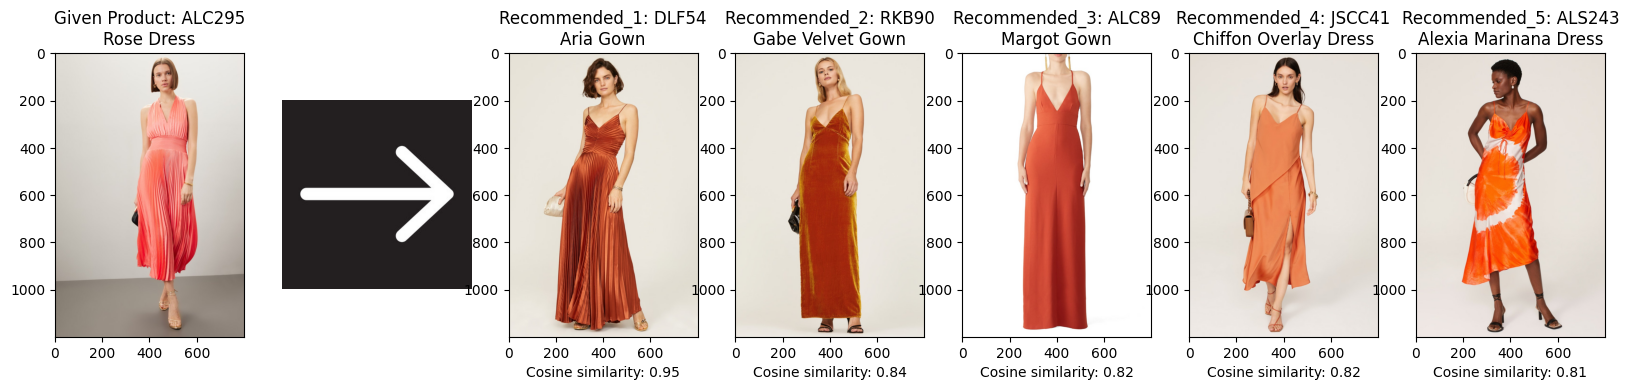

In [90]:
content_based_recommendation('ALC295')

               BJN52                                   product_img_link  \
product_id                                                                
BJN52       1.000000  https://pc-ap.rtrcdn.com/productimages/front/1...   
ROSI12      0.898545  https://pc-ap.rtrcdn.com/productimages/front/1...   
LRL188      0.835740  https://pc-ap.rtrcdn.com/productimages/front/1...   
PSC1        0.822534  https://pc-ap.rtrcdn.com/productimages/front/1...   
MWC80       0.802036  https://pc-ap.rtrcdn.com/productimages/front/1...   
RRR6        0.792381  https://pc-ap.rtrcdn.com/productimages/front/1...   

                          displayName            designer_name  
product_id                                                      
BJN52                      Jana Dress                 Banjanan  
ROSI12                Buttercup Dress           Rosie Assoulin  
LRL188                    Hamisi Gown      Lauren Ralph Lauren  
PSC1        Multi Color Floral Blouse     Peter Som Collective  
MWC80    

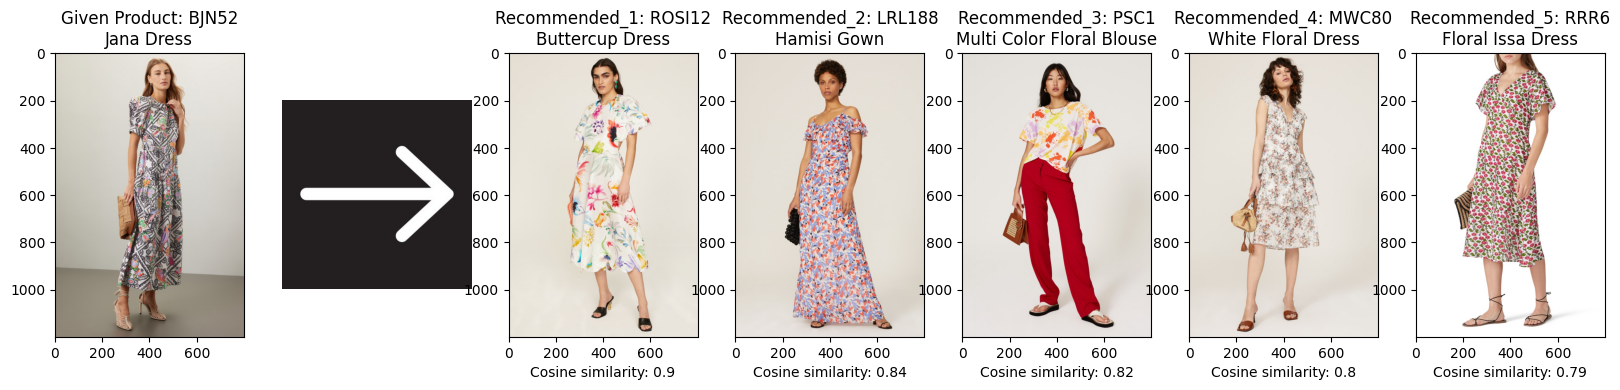

In [91]:
content_based_recommendation('BJN52')

              CECE13                                   product_img_link  \
product_id                                                                
CECE13      1.000000  https://pc-ap.rtrcdn.com/productimages/front/1...   
RT338       0.936171  https://pc-ap.rtrcdn.com/productimages/front/1...   
KS386       0.830870  https://pc-ap.rtrcdn.com/productimages/front/1...   
CLUB159     0.819411  https://pc-ap.rtrcdn.com/productimages/front/1...   
SCS166      0.803579  https://pc-ap.rtrcdn.com/productimages/front/1...   
BSH124      0.803157  https://pc-ap.rtrcdn.com/productimages/front/1...   

                          displayName        designer_name  
product_id                                                  
CECE13             Puff Sleeve Jacket                 CeCe  
RT338                Tie Waist Blouse       Rebecca Taylor  
KS386           Spring Argyle Sweater  kate spade new york  
CLUB159     Texture Tie Back Jumpsuit          Club Monaco  
SCS166                Smiling T-s

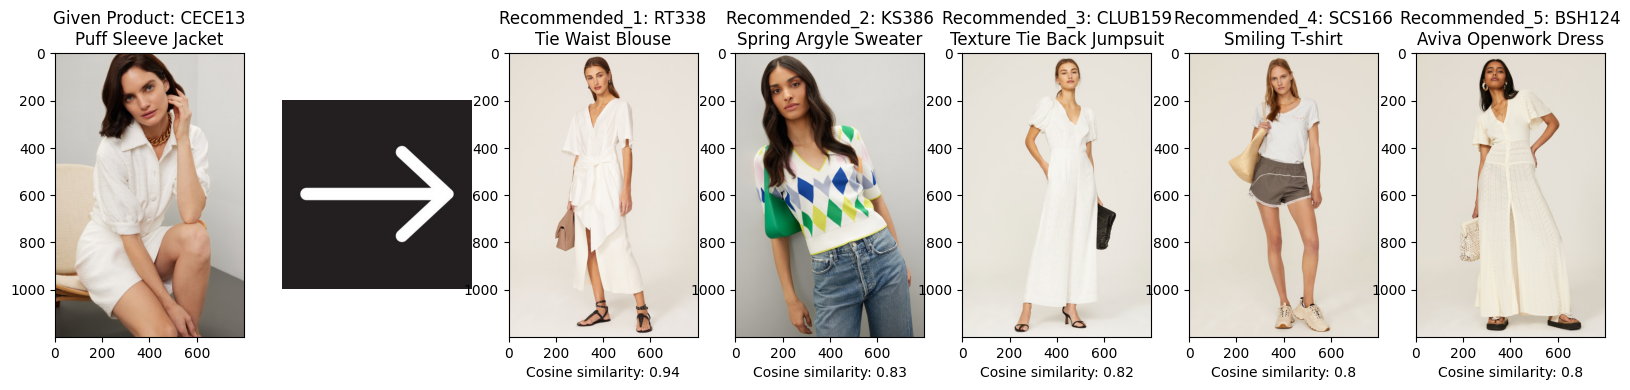

In [92]:
content_based_recommendation('CECE13')

              HTC237                                   product_img_link  \
product_id                                                                
HTC237      1.000000  https://pc-ap.rtrcdn.com/productimages/front/1...   
KS330       0.805223  https://pc-ap.rtrcdn.com/productimages/front/1...   
TOCC24      0.786208  https://pc-ap.rtrcdn.com/productimages/front/1...   
DLF51       0.765842  https://pc-ap.rtrcdn.com/productimages/front/1...   
TOC85       0.751764  https://pc-ap.rtrcdn.com/productimages/front/1...   
RGC66       0.751579  https://pc-ap.rtrcdn.com/productimages/front/1...   

                             displayName             designer_name  
product_id                                                          
HTC237                   Lora Midi Dress                     Hutch  
KS330       Rooftop Garden Riveria Dress       kate spade new york  
TOCC24              Tie Front Bubble Top              TOCCIN X RTR  
DLF51                         Donna Maxi          DELF

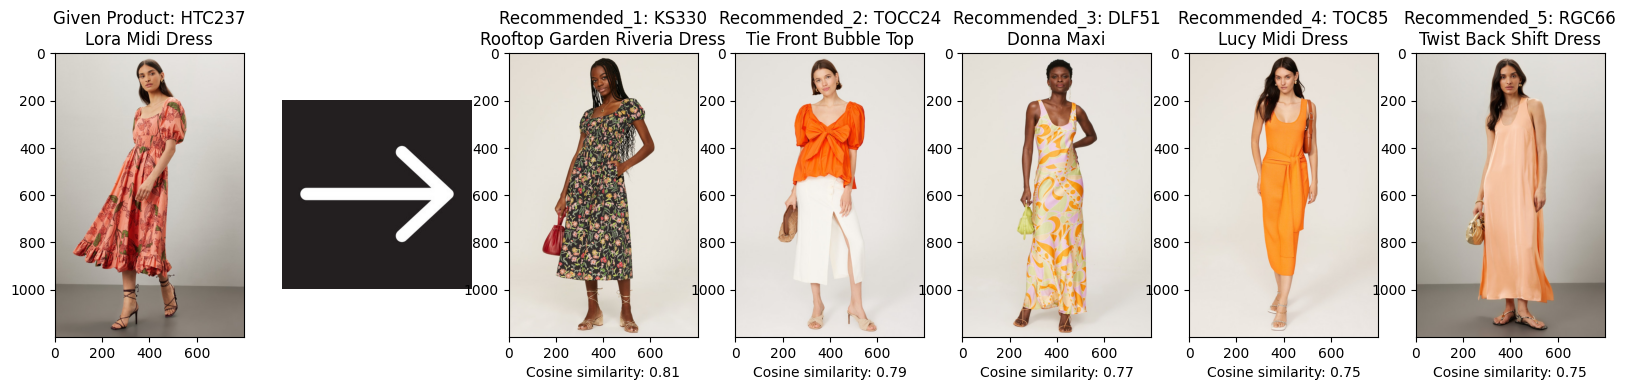

In [93]:
content_based_recommendation('HTC237')

               STA53                                   product_img_link  \
product_id                                                                
STA53       1.000000  https://pc-ap.rtrcdn.com/productimages/front/1...   
LPJ33       0.970502  https://pc-ap.rtrcdn.com/productimages/front/1...   
LSPE118     0.965027  https://pc-ap.rtrcdn.com/productimages/front/1...   
YZF44       0.961938  https://pc-ap.rtrcdn.com/productimages/front/1...   
LS170       0.959763  https://pc-ap.rtrcdn.com/productimages/front/1...   
MGLA56      0.957676  https://pc-ap.rtrcdn.com/productimages/front/1...   

                               displayName               designer_name  
product_id                                                              
STA53       Tommy Blue Swimmers Beaded Bag           Staud Accessories  
LPJ33                             Lexi Bag          Les Petits Joueurs  
LSPE118        Multi Crystal Lily Earrings               Lele Sadoughi  
YZF44                            M

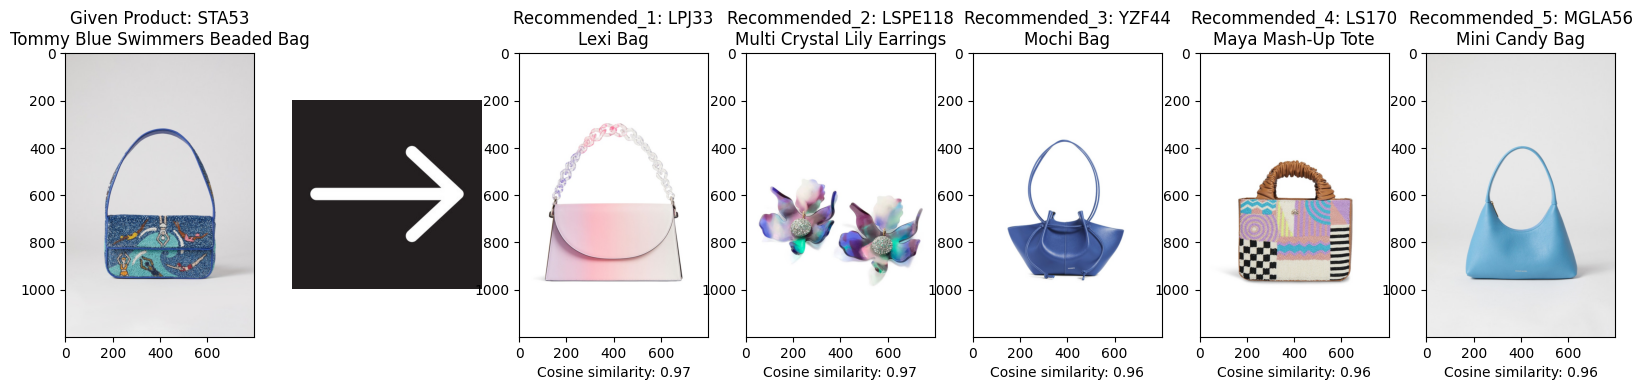

In [94]:
content_based_recommendation('STA53')